In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import  tqdm
import time
import sys
sys.path.append("../../")
from src.util import operators
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_nonlinear as compute_exp_val_nonlinear
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_linear as compute_exp_val_linear
from src.util import bath_correlation_function
from src.util import debye_spectral_density  
from src.homps import homps
from src.util import operators
from src.hops import hops
from src.util import noise_generator

In [102]:
def extract_auxillary_state(psi, n):
    contr = psi.Bs[-1][:, 0, n[-1]] # vL
    for i in range(N_terms-1, 0, -1):
        contr = np.tensordot(psi.Bs[i][:, :, n[-1-i]], contr, ([1], [0])) # vL [vR], [vL] -> vL
    result = np.tensordot(psi.Bs[0][0, :, :], contr, ([0], [0])) # [vR] i, [vL] -> i
    return result * psi.norm

# High T

In [3]:
# Parameters for the spin-boson model
epsilon = 2.0
delta = -2.0
# Parameters for the Debye spectral density
beta = 0.5
T = 1/beta
gamma = 0.25
eta = 0.5
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
L = sigma_z
h = operators.generate_spin_boson_hamiltonian(delta=delta, epsilon=epsilon)
# time window
duration = 30

In [4]:
N_terms = 1

In [5]:
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta)

In [43]:
N_steps = 1000
N_trunc = 40
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 0,
    'method' : 'RK4',
    'rescale_aux' : True
}

In [44]:
options['rescale_aux'] = True
my_homps_rescaled = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
psis_rescaled = my_homps_rescaled.compute_realizations(1, collect_debug_info=True)

In [45]:
options['rescale_aux'] = False
my_homps_default = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
psis_default = my_homps_default.compute_realizations(1, collect_debug_info=True)

In [46]:
sigma_zs_rescaled = compute_exp_val_linear(psis_rescaled, sigma_z)
sigma_zs_default = compute_exp_val_linear(psis_default, sigma_z)

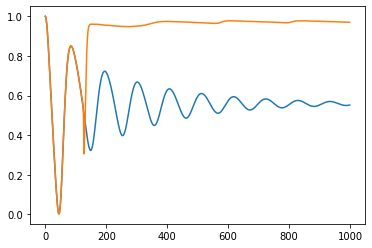

In [47]:
plt.plot(sigma_zs_rescaled)
plt.plot(sigma_zs_default)
plt.show()

In [48]:
# Extract auxillary states from default HOPS
auxillary_states_default = np.empty((N_trunc, N_steps, 2), dtype=complex)
auxillary_magnitudes_default = np.empty((N_trunc, N_steps), dtype=complex)
for n in range(N_trunc):
    for i in range(N_steps):
        auxillary_states_default[n, i, :] = extract_auxillary_state(my_homps_default.debug_info['full_state'][0][i], [n])
        auxillary_magnitudes_default[n, i] = np.linalg.norm(auxillary_states_default[n, i, :])

In [49]:
# Extract auxillary states from rescaled HOPS
auxillary_states_rescaled = np.empty((N_trunc, N_steps, 2), dtype=complex)
auxillary_magnitudes_rescaled = np.empty((N_trunc, N_steps), dtype=complex)
for n in range(N_trunc):
    for i in range(N_steps):
        auxillary_states_rescaled[n, i, :] = extract_auxillary_state(my_homps_rescaled.debug_info['full_state'][0][i], [n])
        auxillary_magnitudes_rescaled[n, i] = np.linalg.norm(auxillary_states_rescaled[n, i, :])

In [70]:
taus = np.linspace(0, 30, N_steps)
colors = ['#fee0d2', '#ffdccd', '#ffd8c7', '#ffd4c2', '#ffd0bd', '#ffcbb8', '#ffc7b3', '#ffc3ae', '#ffbfa9', '#ffbba4', '#ffb69f', '#ffb29a', '#feae95', '#feaa90', '#fda68c', '#fda187', '#fc9d83', '#fb997e', '#fa957a', '#fa9175', '#f98c71', '#f8886c', '#f78468', '#f67f64', '#f47b60', '#f3775c', '#f27257', '#f16e53', '#ef694f', '#ee644b', '#ed6047', '#eb5b44', '#ea5640', '#e8513c', '#e64c38', '#e54634', '#e34131', '#e13b2d', '#e0342a', '#de2d26']

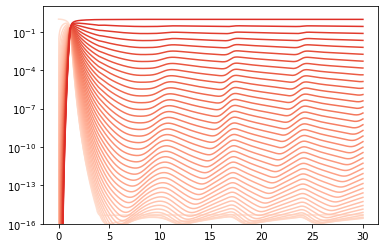

In [71]:
for n in range(N_trunc):
    plt.plot(taus, np.real_if_close(auxillary_magnitudes_default[n]), color=colors[n])
plt.yscale("log")
plt.ylim(10**-16, 10**1)
plt.show()

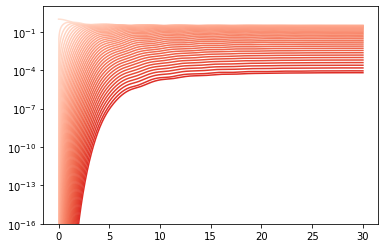

In [72]:
for n in range(N_trunc):
    plt.plot(taus, np.real_if_close(auxillary_magnitudes_rescaled[n]), color=colors[n])
plt.yscale("log")
plt.ylim(10**-16, 10**1)
plt.show()

In [53]:
final_magnitudes_default = auxillary_magnitudes_default[:, -1]
final_magnitudes_rescaled = auxillary_magnitudes_rescaled[:, -1]

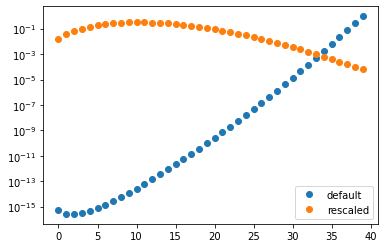

In [60]:
plt.plot(np.arange(N_trunc), np.real_if_close(final_magnitudes_default), "o", label="default")
plt.plot(np.arange(N_trunc), np.real_if_close(final_magnitudes_rescaled), "o", label="rescaled")
plt.yscale("log")
plt.legend()
plt.show()

# low T

In [74]:
# Parameters for the spin-boson model
epsilon = 2.0
delta = -2.0
# Parameters for the Debye spectral density
beta = 50.0
T = 1/beta
gamma = 5.0
eta = 0.5
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
L = sigma_z
h = operators.generate_spin_boson_hamiltonian(delta=delta, epsilon=epsilon)
# time window
duration = 30

In [141]:
N_terms = 5

In [142]:
g, w = debye_spectral_density.get_debye_coefficients(N_terms, T, gamma, eta, mode="pade")

In [143]:
N_steps = 2000
N_trunc = 3
options = {
    'linear' : False,
    'use_noise' : False,
    'chi_max' : 10,
    'eps' : 1.e-3,
    'method' : 'RK4',
    'rescale_aux' : True
}

In [144]:
start = time.time()
options['rescale_aux'] = True
my_homps_rescaled = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
psis_rescaled = my_homps_rescaled.compute_realizations(1, collect_debug_info=True)
end = time.time()
print("took", end-start, "seconds!")

In [145]:
start = time.time()
options['rescale_aux'] = False
my_homps_default = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
psis_default = my_homps_default.compute_realizations(1, collect_debug_info=True)
end = time.time()
print("took", end-start, "seconds!")

In [146]:
sigma_zs_rescaled = compute_exp_val_linear(psis_rescaled, sigma_z)
sigma_zs_default = compute_exp_val_linear(psis_default, sigma_z)

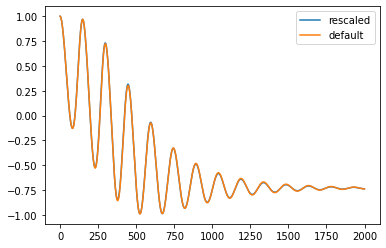

In [147]:
plt.plot(sigma_zs_rescaled, label="rescaled")
plt.plot(sigma_zs_default, label="default")
plt.legend()
plt.show()

In [148]:
def increase_vector_index(n_vec):
    for n in range(N_terms - 1, -1, -1):
        if n_vec[n] < N_trunc - 1:
            n_vec[n] += 1
            return
        n_vec[n] = 0

In [149]:
# Extract auxillary states from default HOPS
auxillary_states_default = np.empty((N_trunc**N_terms, N_steps, 2), dtype=complex)
auxillary_magnitudes_default = np.empty((N_trunc**N_terms, N_steps), dtype=complex)
n_vec = np.zeros(N_terms, dtype=int)
for n in tqdm(range(N_trunc**N_terms)):
    for i in range(N_steps):
        auxillary_states_default[n, i, :] = extract_auxillary_state(my_homps_default.debug_info['full_state'][0][i], n_vec)
        auxillary_magnitudes_default[n, i] = np.linalg.norm(auxillary_states_default[n, i, :])
    increase_vector_index(n_vec)

  0%|          | 0/243 [00:00<?, ?it/s]

In [150]:
# Extract auxillary states from rescaled HOPS
auxillary_states_rescaled = np.empty((N_trunc**N_terms, N_steps, 2), dtype=complex)
auxillary_magnitudes_rescaled = np.empty((N_trunc**N_terms, N_steps), dtype=complex)
n_vec = np.zeros(N_terms, dtype=int)
for n in tqdm(range(N_trunc**N_terms)):
    for i in range(N_steps):
        auxillary_states_rescaled[n, i, :] = extract_auxillary_state(my_homps_rescaled.debug_info['full_state'][0][i], n_vec)
        auxillary_magnitudes_rescaled[n, i] = np.linalg.norm(auxillary_states_rescaled[n, i, :])
    increase_vector_index(n_vec)

  0%|          | 0/243 [00:00<?, ?it/s]

In [151]:
taus = np.linspace(0, 30, N_steps)

In [154]:
colors = ['#fee0d2', '#ffd3c1', '#ffc5b0', '#ffb8a0', '#feaa90', '#fc9c81', '#f98e73', '#f68065', '#f27257', '#ee634a', '#e9533e', '#e44232', '#de2d26']

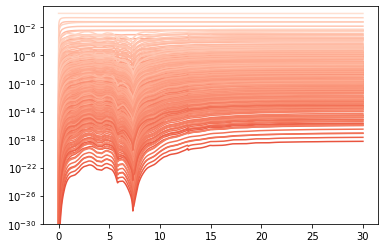

In [157]:
n_vec = np.zeros(N_terms, dtype=int)
for n in range(N_trunc**N_terms):
    n_mag = np.sum(n_vec)
    plt.plot(taus, np.real_if_close(auxillary_magnitudes_default[n]), color=colors[n_mag])
    increase_vector_index(n_vec)
plt.yscale("log")
plt.ylim(10**-30, 10**1)
plt.show()

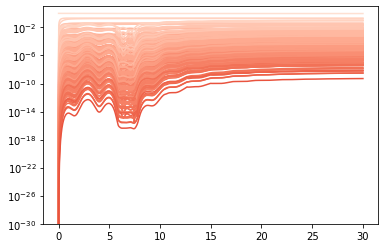

In [158]:
n_vec = np.zeros(N_terms, dtype=int)
for n in range(N_trunc**N_terms):
    n_mag = np.sum(n_vec)
    plt.plot(taus, np.real_if_close(auxillary_magnitudes_rescaled[n]), color=colors[n_mag])
    increase_vector_index(n_vec)
plt.yscale("log")
plt.ylim(10**-30, 10**1)
plt.show()

In [159]:
final_magnitude_n_vec = []
final_magnitudes_default = []
final_magnitudes_rescaled = []
n_vec = np.zeros(N_terms, dtype=int)
for n in tqdm(range(N_trunc**N_terms)):
    n_mag = np.sum(n_vec)
    final_magnitude_n_vec.append(n_mag)
    final_magnitudes_default.append(np.real_if_close(np.linalg.norm(auxillary_magnitudes_default[n])))
    final_magnitudes_rescaled.append(np.real_if_close(np.linalg.norm(auxillary_magnitudes_rescaled[n])))
    increase_vector_index(n_vec)

  0%|          | 0/243 [00:00<?, ?it/s]

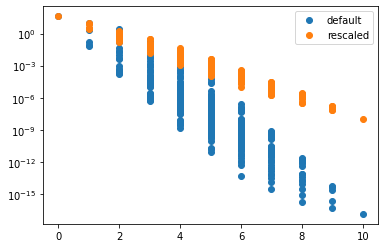

In [160]:
plt.plot(final_magnitude_n_vec, np.real_if_close(final_magnitudes_default), "o", label="default")
plt.plot(final_magnitude_n_vec, np.real_if_close(final_magnitudes_rescaled), "o", label="rescaled")
plt.yscale("log")
plt.legend()
plt.show()